In [1]:
from ThesisFunctions import *

In [ ]:
print('Number of datapoints vs Number of minimas')
noise_level = 0.25
#num_datapoints_list = [2, 3, 4, 5, 6, 7, 8, 9 , 10, 20]
num_datapoints_list = [6]

# Initialize a list to store the results.
results_list = []
data = 0 
t_i = 0
x_i = 0

for num_datapoints in num_datapoints_list:
    trials_minimas = []  # Store the number of minima found in each trial for current num_datapoints.
    
    for _ in range(100):  # Perform 10 trials to average out the effects of randomness.
        # Generate data with specified number of datapoints and noise level.
        data = data_gen(num_datapoints, noise_level, 1, 1)
        x_i = np.array(data['Data'].values)
        t_i = np.array(data['Time'].values)
        plt.scatter(t_i, x_i)
        
        # Calculate the Groebner basis.
        B = groeb(x_i, t_i)
                            
        # Find positive real roots.
        positive_roots_b = roots_symbolic(B[1])

        if positive_roots_b == []:
            positive_roots_b = find_roots_alternative(B[1])
        # Determine (x0, alpha) pairs.

        elif len(positive_roots_b) != count_positive_roots(B[1]):
            print("some roots missing")
            print(positive_roots_b)
            print(count_positive_roots(B[1]))
            break
        
        params = find_x0_alpha_pairs(B, positive_roots_b)
    
        # Evaluate the Hessian to check for minima.
        maxima_checks = evaluate_hessian_at_extremas(params, x_i, t_i)
            
        # Count the number of minima.
        num_minimas = sum(1 for _, is_true in maxima_checks if is_true)
        if num_minimas == 0:
            print("zero")
            break

        trials_minimas.append(num_minimas)

    
    # Calculate the average number of minima for the current number of data points.
    avg_minimas = np.mean(trials_minimas)
    results_list.append({'Number_of_Datapoints': num_datapoints, 'Average_Number_of_Minimas': avg_minimas})

# Convert results to a DataFrame for better visualization.
results_df = pd.DataFrame(results_list)

# Print the DataFrame to see the results.
print(results_df)


Number of datapoints vs Number of minimas


In [ ]:
def find_roots_alternative(poly):
    b = sp.symbols('b')
    
    # Convert sympy polynomial to a function for Newton's method
    poly_func = sp.lambdify(b, poly, 'numpy')
    poly_derivative = sp.diff(poly, b)
    poly_derivative_func = sp.lambdify(b, poly_derivative, 'numpy')
    
    # Call sturm algo
    num_positive_roots = count_positive_roots(poly)

    # Call Newton Method
    positive_roots = find_roots_newton(poly_func, poly_derivative_func, num_positive_roots)

    return positive_roots


# Newton's method to find roots
def find_roots_newton(func, func_prime, num_roots, initial_guess_range=(0, 10), max_attempts_per_root=100):
    roots_found = []
    for _ in range(num_roots):
        root_found = False
        attempts = 0
        while not root_found and attempts < max_attempts_per_root:
            initial_guess = np.random.uniform(*initial_guess_range)
            try:
                root = newton(func, initial_guess, fprime=func_prime, maxiter=50)
                if root>0 and all(abs(root - found_root) > 1e-5 for found_root in roots_found):
                    roots_found.append(root)
                    root_found = True
            except RuntimeError:
                pass  # Handle case where Newton's method fails
            attempts += 1
        if not root_found:
            raise ValueError("Failed to find all positive roots after specified attempts.")
    
    
    #Making sure the roots are positive MISLEADING?
    
    
    ret = [root for root in roots_found if root>0]
    return ret



In [91]:
data

,Time,Data
0,0,43/100
1,1,157/50
2,2,401/50
3,3,23
4,4,1811/100
5,5,19343/100


In [92]:
data

,Time,Data
0,0,43/100
1,1,157/50
2,2,401/50
3,3,23
4,4,1811/100
5,5,19343/100


In [93]:
t_i, x_i

(array([0, 1, 2, 3, 4, 5]),
 array([43/100, 157/50, 401/50, 23, 1811/100, 19343/100], dtype=object))

In [94]:
B = groeb(x_i, t_i)
B

GroebnerBasis([-4903565610393576082177614999296862677379649*b**17/17323997697726215229524402223854458870074048 - 221491860084923040365452120485403229251122949*b**16/54137492805394422592263756949545183968981400 + 11166126024747276286754480909404794356084927407*b**15/216549971221577690369055027798180735875925600 + 425119563391664121332744167486425574277184593*b**14/433099942443155380738110055596361471751851200 + 14395430733369586533820093378278749212732430253*b**13/144366647481051793579370018532120490583950400 + 1658799873048167508472583262563961210244844551*b**12/108274985610788845184527513899090367937962800 + 3291718910021308082586208769128835092126539709*b**11/22794733812797651617795266084019024829044800 + 3723504532369457301168312247639734559157393629*b**10/144366647481051793579370018532120490583950400 + 4039832690120051933357793803014579152151943899*b**9/21654997122157769036905502779818073587592560 + 242580224017194269958348680904290479969751047*b**8/67671866006743028240329696186931

In [95]:
positive_roots_b = roots_symbolic(B[1])
positive_roots_b

[8.27066162324984]

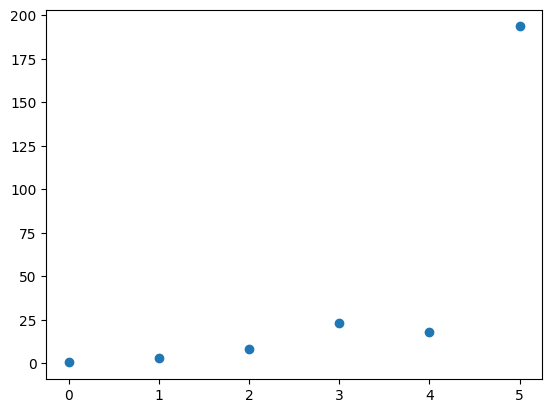

In [96]:
plt.scatter(t_i, x_i)

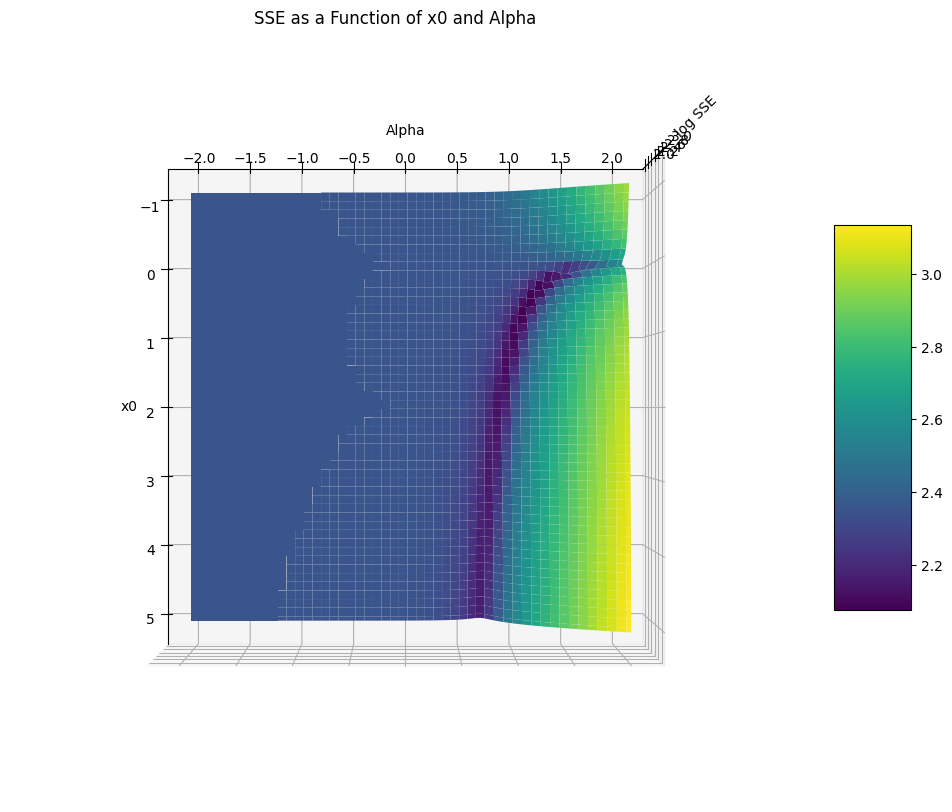

In [97]:
# Define the range for alpha and x0
alpha_range = np.linspace(-2, 2, 100)  # Adjust the range as needed
x0_range = np.linspace(-1, 5, 100)  # Adjust the range as needed


# Generate a meshgrid for x0 and alpha ranges
X0, Alpha = np.meshgrid(x0_range, alpha_range)


# Initialize an array to store SSE values
SSE_values = np.zeros(X0.shape)


# Compute SSE for each combination of x0 and alpha
for i in range(len(alpha_range)):
    for j in range(len(x0_range)):
        params_ = (X0[i, j], Alpha[i, j])
        SSE_values[i, j] = sse(params_, data)

        
# Creating the plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')


# Surface plot with log scale (since data is exponential)
surf = ax.plot_surface(X0, Alpha, np.log(np.log(SSE_values)), cmap='viridis', edgecolor='none')


# Labels and title
ax.set_xlabel('x0')
ax.set_ylabel('Alpha')
ax.set_zlabel('log SSE')
ax.set_title('SSE as a Function of x0 and Alpha')


# Colorbar to show the SSE scale better/clearer
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(elev=90, azim=0)

# Show the plot with the adjusted view
plt.show()


In [54]:
# Assuming your model and sse functions are defined as in your previous messages

# Initial guess for the parameters [x0, alpha]
initial_guess = [1.0, 0.1]

# Minimization process
result = minimize(sse, initial_guess, args=(data,), method='L-BFGS-B', bounds=[(0, None), (None, None)])

# Results
optimized_x0 = result.x[0]
optimized_alpha = result.x[1]
success = result.success
sse_min = result.fun

print(f"Optimization Success: {success}")
print(f"Optimized x0: {optimized_x0}")
print(f"Optimized alpha: {optimized_alpha}")
print(f"Minimum SSE: {sse_min}")


Optimization Success: True
Optimized x0: 1.6491497877717656
Optimized alpha: 0.5253027742206136
Minimum SSE: 0.788253266042978


In [56]:
x0, b = sp.symbols('x0 b')
x0_recon = sp.solve(B[0].subs(b, beta), x0)[0]
x0_recon

1.64914947174533

In [57]:
test = B[1].subs(b, beta)


In [58]:
test

2.91173207034312e-6

In [60]:
print(B[1])

b**6 + 4419*b**5/51980 - 125*b**4/452 - 64141*b**3/25990 - 1247*b**2/452 - 3428*b/2599 - 109/452


In [55]:
beta = np.exp(optimized_alpha)
beta

1.6909707532312743